In [15]:
import pandas as pd

In [16]:
data_set = pd.read_csv('GC_larger.csv')
data_set.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0.0
1,2000-09-04,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2.0


In [17]:
data_set.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
5313,2021-07-15,1831.599976,1833.000000,1823.400024,1828.400024,1828.400024,99.0
5314,2021-07-16,1830.099976,1831.400024,1814.500000,1814.500000,1814.500000,78.0
5315,2021-07-19,1803.300049,1813.400024,1803.300049,1808.699951,1808.699951,78.0


In [18]:
data_set.isnull().sum()

Date           0
Open         112
High         112
Low          112
Close        112
Adj Close    112
Volume       112
dtype: int64

In [19]:
data_set = data_set.dropna().reset_index(drop=True)

In [20]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
index_test = int(len(data_set)*0.8) + (len(data_set)%0.8> 0)
index_test=4096+timesteps

In [26]:
base_treinamento = data_set.iloc[:index_test, 1:2].values
base_treinamento.shape

(4103, 1)

In [27]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
print(base_treinamento_normalizada.shape)

(4103, 1)


In [28]:
previsores = []
preco_real = []
timesteps = 7
for i in range(timesteps, len(base_treinamento_normalizada)):
    previsores.append(base_treinamento_normalizada[i-timesteps:i, 0])
    preco_real.append(base_treinamento_normalizada[i, 0])
previsores, preco_real = np.array(previsores), np.array(preco_real)
print(previsores.shape)
print(preco_real.shape)

(4096, 7)
(4096,)


In [29]:
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))
previsores.shape

(4096, 7, 1)

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.layers import Convolution1D, MaxPooling1D, Flatten,  Embedding
from keras.layers.normalization import BatchNormalization
from keras_self_attention import SeqSelfAttention
import keras

In [31]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

model=Sequential()

model.add(LSTM(100, activation='relu', input_shape=(timesteps,1)))


model.add(Dense(units = 1, activation='linear'))

#Compiling
model.compile(optimizer='RMSprop', loss = 'mse')
#Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(previsores, preco_real, epochs = 200, batch_size = 16)

Epoch 1/200
256/256 [==============================] - 1s 4ms/step - loss: 0.0060
Epoch 2/200
256/256 [==============================] - 1s 4ms/step - loss: 6.4955e-04
Epoch 3/200
256/256 [==============================] - ETA: 0s - loss: 5.6209e-0 - 1s 4ms/step - loss: 5.5197e-04
Epoch 4/200
256/256 [==============================] - 1s 4ms/step - loss: 5.1022e-04
Epoch 5/200
256/256 [==============================] - 1s 4ms/step - loss: 4.5201e-04
Epoch 6/200
256/256 [==============================] - 1s 4ms/step - loss: 4.1055e-04
Epoch 7/200
256/256 [==============================] - 1s 4ms/step - loss: 3.9688e-04
Epoch 8/200
256/256 [==============================] - 1s 4ms/step - loss: 3.2683e-04
Epoch 9/200
256/256 [==============================] - 1s 4ms/step - loss: 3.1637e-04
Epoch 10/200
256/256 [==============================] - 1s 4ms/step - loss: 2.9015e-04
Epoch 11/200
256/256 [==============================] - 1s 4ms/step - loss: 2.8037e-04
Epoch 12/200
256/256 [======

In [33]:
preco_real_open = data_set.iloc[ index_test:, 1:2].values

In [34]:
entradas = data_set.iloc[ index_test-timesteps:, 1:2].values

entradas = entradas.reshape(-1, 1)
entradas = normalizador.transform(entradas)
entradas.shape

(1108, 1)

In [35]:
X_teste = []
for i in range(timesteps, len(entradas)):
    X_teste.append(entradas[i-timesteps:i, 0])
X_teste = np.array(X_teste)
X_teste.shape

(1101, 7)

In [36]:
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
X_teste.shape

(1101, 7, 1)

In [37]:
previsoes = model.predict(X_teste)
previsoes.shape

(1101, 1)

In [38]:
previsoes = normalizador.inverse_transform(previsoes)
previsoes.shape

(1101, 1)

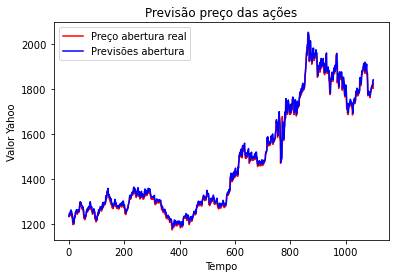

In [39]:
plt.plot(preco_real_open, color = 'red', label = 'Preço abertura real')

plt.plot(previsoes[:, 0], color = 'blue', label = 'Previsões abertura')


plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [41]:
print(mean_squared_error(preco_real_open, previsoes[:, 0]))
print(mean_absolute_error(preco_real_open, previsoes[:, 0]))

281.6102216438396
12.03204384607743
